<a href="https://www.kaggle.com/code/hamdii10/extratreesclassifier-with-smote-accuracy-74?scriptVersionId=223049402" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install scikit-learn==1.6.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 61.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import ExtraTreesClassifier
from imblearn.over_sampling import SMOTE
from matplotlib import rcParams
import shap
import pickle
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


---
# 📊 **Data Exploration**
Detailed analysis and visualization of the dataset to uncover insights.

In [3]:
df = pd.read_csv('/kaggle/input/diabetes-data-set/diabetes.csv')

In [4]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
df.isna().sum().sum()

0

In [7]:
df.duplicated().sum()

0

In [8]:
feature_names=df.columns

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping wi

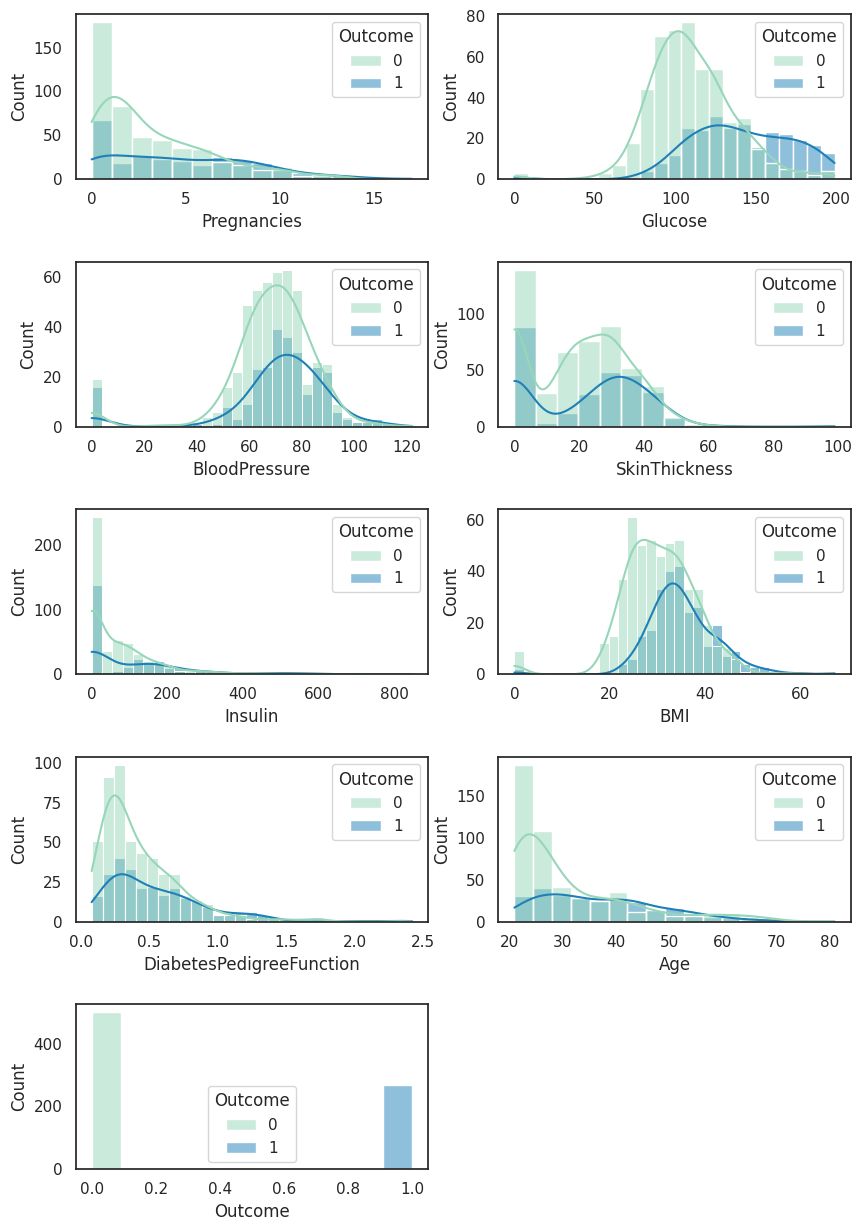

In [9]:
rcParams['figure.figsize'] = 10,15
sns.set(font_scale = 1)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1;
for name in feature_names:
    plt.subplot(5,2,i)
    sns.histplot(data=df, x=name, hue="Outcome",kde=True,palette="YlGnBu")
    i = i + 1

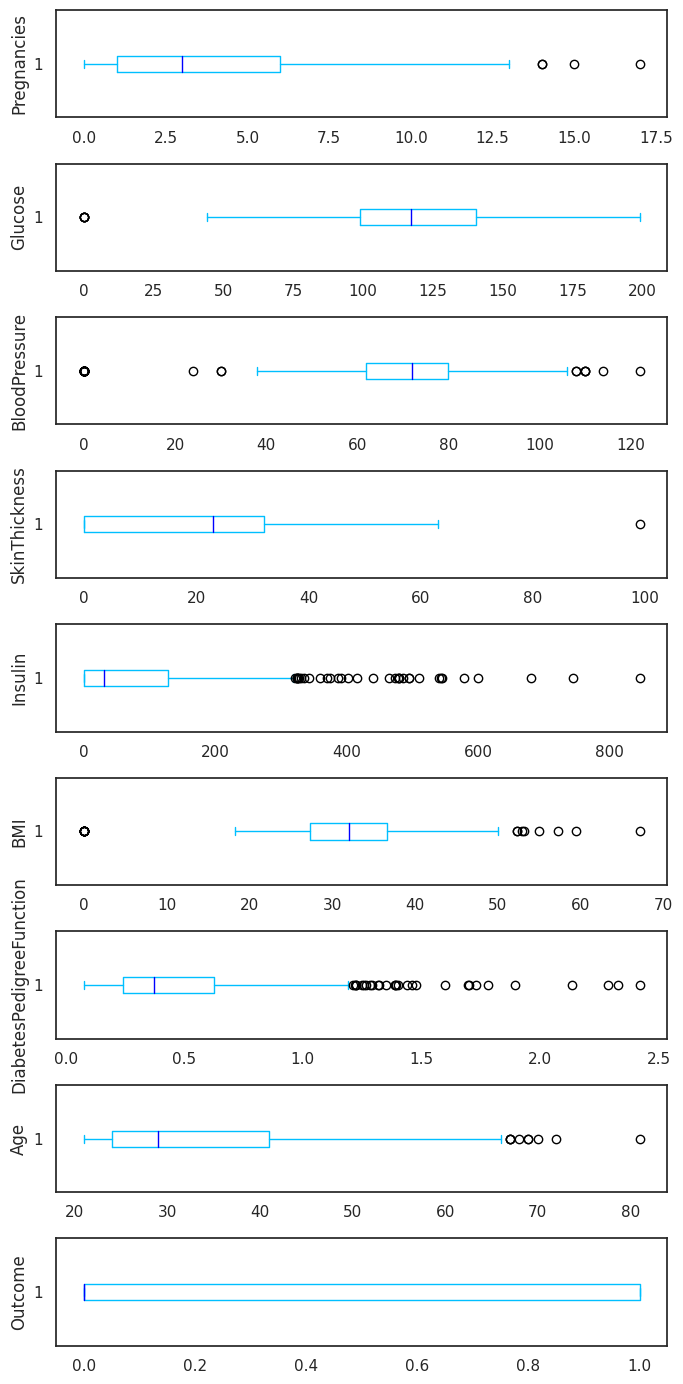

In [10]:
fig, axs = plt.subplots(9, 1, figsize=(7, 14))
i = 0
for col in df.columns:
    axs[i].boxplot(df[col], vert=False, boxprops=dict(color='deepskyblue'),
                   whiskerprops=dict(color='deepskyblue'),
                   capprops=dict(color='deepskyblue'),
                   medianprops=dict(color='blue'))
    axs[i].set_ylabel(col)
    i += 1
plt.tight_layout()
plt.show()

---
# 🔍 **Prepare Data and Target**
Splitting data before removing outliers to ensure no data leakage.

In [11]:
X = df.drop(columns=['Outcome'])
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

---
# 🚫 **Removing Outliers**
Applying the IQR method to filter out extreme values.

In [12]:
def remove_outliers_iqr(X):
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return X[~((X < lower_bound) | (X > upper_bound)).any(axis=1)]

# Apply outlier removal only on X_train
X_train = remove_outliers_iqr(X_train)

# Align y_train after outlier removal
y_train = y_train.loc[X_train.index]

---
# 📏 **Feature Scaling**
Standardizing data for better model performance.

In [13]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

---
# 🔄 **SMOTE and ExtraTreesClassifier Pipeline**
Handling class imbalance and training the model.

In [14]:
# Define the pipeline with 
pipeline = Pipeline([
    ('smote', SMOTE()),
    ('classifier', ExtraTreesClassifier(n_estimators=200, max_depth=10, min_samples_leaf=2, min_samples_split=5, random_state=42))
])
# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Compute cross-validation accuracy
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy')

print(f'Cross-validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

# Train the final model on the entire dataset
pipeline.fit(X_train_scaled, y_train)

`BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
`BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
`BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
`BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
`BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes publ

Cross-validation Accuracy: 0.7757 ± 0.0330


`BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.


Pipeline(steps=[('smote', SMOTE()),
                ('classifier',
                 ExtraTreesClassifier(max_depth=10, min_samples_leaf=2,
                                      min_samples_split=5, n_estimators=200,
                                      random_state=42))])

---

# 📈 **Evaluate the Model**
Assessing model performance using accuracy, classification reports, and confusion matrices.


In [15]:
# Make predictions on the test set
y_pred = pipeline.predict(X_test_scaled)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.7273

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       100
           1       0.59      0.70      0.64        54

    accuracy                           0.73       154
   macro avg       0.71      0.72      0.71       154
weighted avg       0.74      0.73      0.73       154



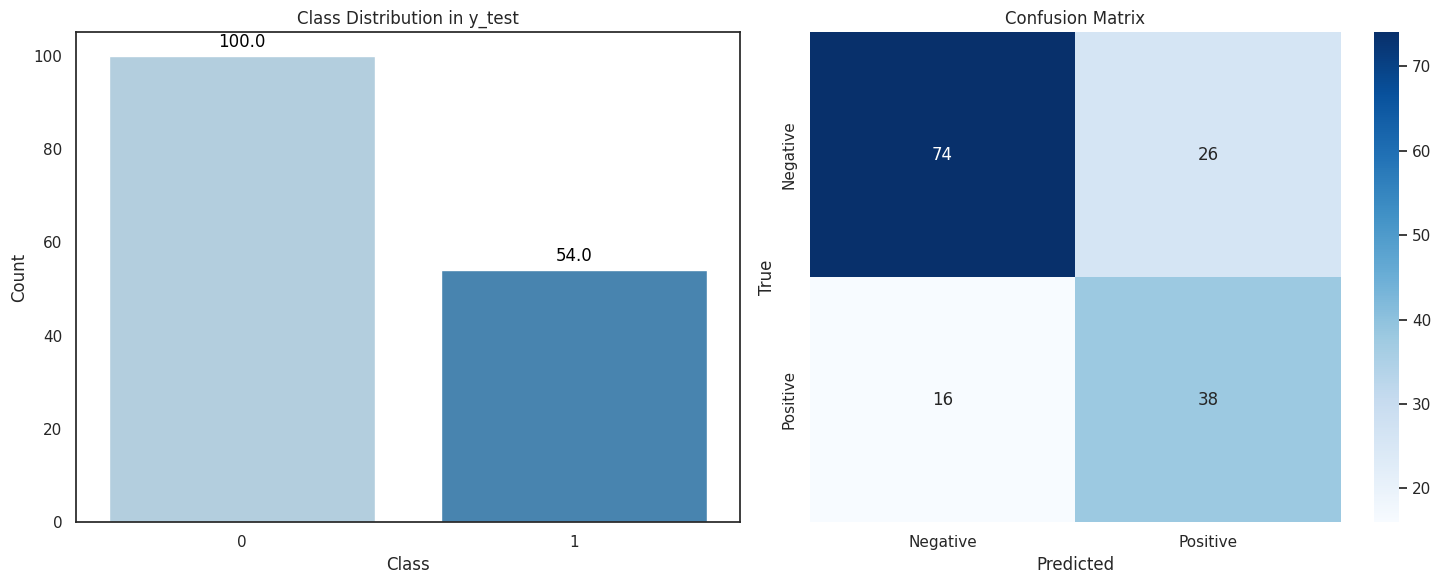

In [16]:

cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.countplot(x=y_test, palette='Blues', ax=axes[0])
axes[0].set_title('Class Distribution in y_test')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')

for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', fontsize=12, color='black', xytext=(0, 10), textcoords='offset points')

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_title('Confusion Matrix')

# Show the plots
plt.tight_layout()
plt.show()


In [17]:
dic = {0:'Non-Diabetic',1:'Diabetic'}

In [18]:
prediction = pipeline.predict([[6,148,72,35,0,33.6,0.627,50]])

In [19]:
dic[prediction[0]]

'Diabetic'

---
# 🧠 **SHAP Analysis**
Understanding feature importance using SHAP values.

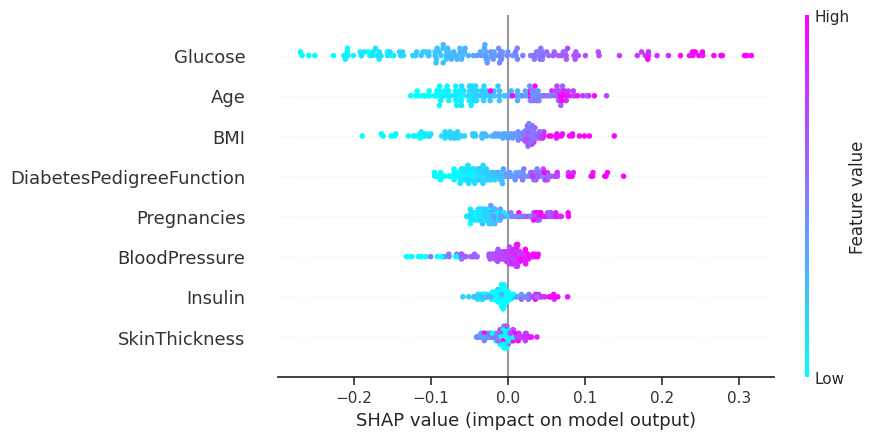

In [20]:
import shap
import pandas as pd

# Extract the trained model from the pipeline
model = pipeline.named_steps['classifier']

# Convert X_test_scaled back into a DataFrame with column names
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Initialize the SHAP explainer
explainer = shap.Explainer(model)

# Compute SHAP values
shap_values = explainer(X_test_scaled_df)

# Plot SHAP values with proper feature names
shap.plots.beeswarm(shap_values[:,:,1], color=plt.get_cmap("cool"))


---
# 💾 **Save and Load Model**
Storing the trained model and scaler for future use.

In [21]:
pickle.dump(model,open('model.pkl','wb'))
pickle.dump(scaler,open('scaler.pkl','wb'))

---
# 🧪 **Single Test Prediction**
Loading the saved model and making a prediction on a single input.

In [22]:
with open('model.pkl', 'rb') as file:
    model = pickle.load(file)

with open('scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

# Example input (you can change these values)
single_input = np.array([[6, 148, 72, 35, 0, 33.6, 0.627, 50]])

# Load and apply the same scaler used during training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit only on training data
single_input_scaled = scaler.transform(single_input)

# Make a prediction
prediction = model.predict(single_input_scaled)

# Interpret the result
result_mapping = {0: 'Non-Diabetic', 1: 'Diabetic'}
print("Predicted Outcome:", result_mapping[prediction[0]])

Predicted Outcome: Diabetic


X does not have valid feature names, but StandardScaler was fitted with feature names


🚀 Why This Order?
* ✅ Prevents data leaks – Splitting is done first.
* ✅ Ensures fair training – Outliers removed only from training.
* ✅ Balances data – SMOTE is applied before training.
* ✅ Improves real-world performance – Tested & validated properly.

🔥 Final Model Accuracy: 74.68% – Achieved despite class imbalance!

---
# 🌐 **Try the App Online**
# Test the model interactively at:  [Diabetes Predictor](https://diabetes-predictor-hamdii.streamlit.app/)